### Text Classification with Naive Bayes, Logistic Regression, SVM
Dataset from Figure-Eight which consists of approximately 8000 news articles, which were tagged as relevant or not relevant to the US Economy.

Source of code: https://github.com/practical-nlp/practical-nlp-code/blob/master/Ch4/01_OnePipeline_ManyClassifiers.ipynb

In [1]:
import warnings
warnings.filterwarnings('ignore')
from time import time
import string
import re
from collections import Counter
import numpy as np
import pandas as pd # to work with csv files
import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.feature_extraction._stop_words as stop_words
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix 
from imblearn.over_sampling import RandomOverSampler

Get the data:

In [2]:
# try:
#     !wget -P DATAPATH https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch4/Data/Full-Economic-News-DFE-839861.csv
#     !ls -lah DATAPATH

### Step 1: Load and exploratory data analysis
View the data, the size and proportions of the data classes. Reveals a class imbalance.

In [3]:
our_data = pd.read_csv("DATAPATH/Full-Economic-News-DFE-839861.csv" , encoding = "ISO-8859-1" )
display(our_data.head(1))
display(our_data.shape) # Number of rows (instances) and columns in the dataset
our_data["relevance"].value_counts()/our_data.shape[0] # Class distribution in the dataset

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
0,842613455,False,finalized,3,12/5/15 17:48,3.0,0.64,yes,0.64,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NaN,NaN,NEW YORK -- Yields on most certificates of dep...


(8000, 15)

no          0.821375
yes         0.177500
not sure    0.001125
Name: relevance, dtype: float64

Convert the relevance column (our labels) to binary outcomes of yes: 1 and no: 0

In [4]:
our_data = our_data[our_data.relevance != "not sure"] # removing the data where we don't want relevance="not sure".
our_data['relevance'] = our_data.relevance.map({'yes':1, 'no':0}) # relevant is 1, not-relevant is 0. 
our_data = our_data[["text","relevance"]] # Let us take only the two columns we need.

### Step 2: Text Pre-processing
Removing br tags, punctuation, numbers, and stopwords.

In [5]:
stopwords = stop_words.ENGLISH_STOP_WORDS 
print(f'Number of stopwords: {len(stopwords)}')

def clean(doc): # doc is a string of text
    doc = doc.replace("</br>", " ") # This text contains a lot of <br/> tags.
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()]) # remove punctuation and numbers
    doc = " ".join([token for token in doc.split() if token not in stopwords]) # remove stopwords
    return doc

Number of stopwords: 318


### Step 3: Modelling 
1. Split the data into training and test sets (75% train, 25% test)
2. Extract features from the training data using CountVectorizer, which is a bag of words feature implementation. We will use the pre-processing function above in conjunction with Count Vectorizer
3. Transform the test data into the same feature vector as the training data.
4. Train the classifier
5. Evaluate the classifier

Training Data: 5993
Testing Data: 1998
(5993, 49753) (1998, 49753)
Model Training time:
CPU times: user 8.82 ms, sys: 58 µs, total: 8.88 ms
Wall time: 8.77 ms


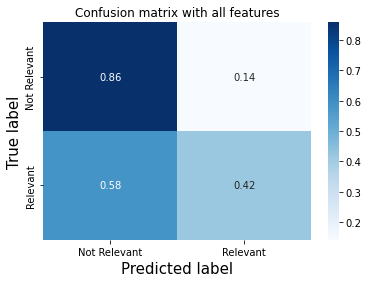

ROC_AOC_Score:  0.7251117679464362
Accuracy:  0.7822822822822822


In [13]:
def plot_confusion_matrix(cm, title):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalise
    lbl_d = {'Not Relevant':'0','Relevant':'1'}
    sn.heatmap(cm, annot=True, fmt='.2', cmap='Blues', xticklabels=lbl_d, yticklabels=lbl_d)
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)
    plt.title(title)
    plt.show()

# Step 1:
X, y = our_data.text, our_data.relevance
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(f'Training Data: {X_train.shape[0]}')
print(f'Testing Data: {X_test.shape[0]}')

# Step 2:
vect = CountVectorizer(preprocessor=clean) 

# Step 3:
X_train_dtm = vect.fit_transform(X_train)# use it to extract features from training data
X_test_dtm = vect.transform(X_test) # transform testing data (using training data's features)
print(X_train_dtm.shape, X_test_dtm.shape)

# Step 4:
print('Model Training time:')
nb = MultinomialNB() # instantiate a Multinomial Naive Bayes model
%time nb.fit(X_train_dtm, y_train) # train the model(timing it with an IPython "magic command")
y_pred_class = nb.predict(X_test_dtm) # make class predictions for X_test_dtm
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]  # class probabilities

# Step 5:
cm = confusion_matrix(y_test, y_pred_class)
plot_confusion_matrix(cm, 'Confusion matrix with all features')
print("ROC_AUC_Score: ", roc_auc_score(y_test, y_pred_prob))
print("Accuracy: ", accuracy_score(y_test, y_pred_class))

Our large feature vector could be creating a lot of noise in the form of very rarely occurring features that are not useful for learning. Let us change the count vectorizer to take a certain number of features as maximum:

CPU times: user 4.71 ms, sys: 27 µs, total: 4.74 ms
Wall time: 4.76 ms


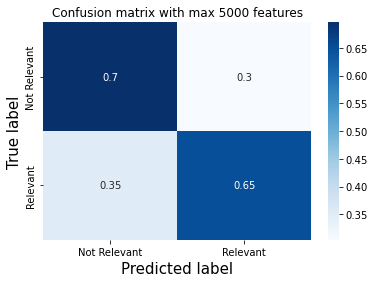

Accuracy:  0.6876876876876877
ROC_AOC_Score:  0.7282608695652173


In [15]:
# Step 2: 
vect = CountVectorizer(preprocessor=clean, max_features=5000)
# Step 3:
X_train_dtm = vect.fit_transform(X_train) # combined step 2 and 3
X_test_dtm = vect.transform(X_test)
# Step 4:
nb = MultinomialNB() # instantiate a Multinomial Naive Bayes model
%time nb.fit(X_train_dtm, y_train) # train the model(timing it with an IPython "magic command")
y_pred_class = nb.predict(X_test_dtm) # make class predictions for X_test_dtm
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]  # class probabilities
# Step 5:
cm = confusion_matrix(y_test, y_pred_class)
plot_confusion_matrix(cm, 'Confusion matrix with max 5000 features')
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("ROC_AUC_Score: ", roc_auc_score(y_test, y_pred_prob))

The performance on relevance classification got better even though the overall accuracy fell by 10%. ROC_AUC improved!

### Let's try balancing the data

Training Data: 5993
Testing Data: 1998
(5993, 49753) (1998, 49753)
[(0, 4915), (1, 4915)]
CPU times: user 9.88 ms, sys: 167 µs, total: 10 ms
Wall time: 9.88 ms


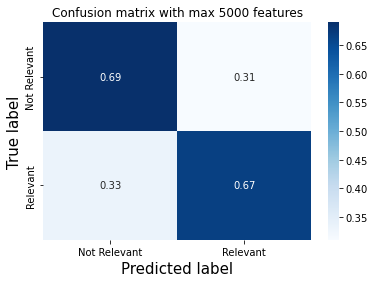

Accuracy:  0.6856856856856857
ROC_AUC_Score:  0.7342386007288754


In [25]:
# Step 1:
X, y = our_data.text, our_data.relevance
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(f'Training Data: {X_train.shape[0]}')
print(f'Testing Data: {X_test.shape[0]}')

# Step 2:
vect = CountVectorizer(preprocessor=clean) 

# Step 3:
X_train_dtm = vect.fit_transform(X_train)# use it to extract features from training data
X_test_dtm = vect.transform(X_test) # transform testing data (using training data's features)
print(X_train_dtm.shape, X_test_dtm.shape)

# NEW RESAMPLE STEP
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train_dtm, y_train)
print(sorted(Counter(y_resampled).items()))

# Step 4:
nb = MultinomialNB() # instantiate a Multinomial Naive Bayes model
%time nb.fit(X_resampled, y_resampled) # train the model(timing it with an IPython "magic command")
y_pred_class = nb.predict(X_test_dtm) # make class predictions for X_test_dtm
y_pred_prob = nb.predict_proba(X_test_dtm)[:, 1]  # class probabilities
# Step 5:
cm = confusion_matrix(y_test, y_pred_class)
plot_confusion_matrix(cm, 'Confusion matrix with max 5000 features')
print("Accuracy: ", accuracy_score(y_test, y_pred_class))
print("ROC_AUC_Score: ", roc_auc_score(y_test, y_pred_prob))

SO using the FULL dataset of 5993 examples with resampling seemed to balance the recall score, i.e. the model sensitiviy to correctly predict the relevant class as relevant and the not relevant class as not relevant. 

`Imbalanced learns over_sampling` algorithm uses random sampling with replacement. There are two popular methods to over-sample minority classes: (i) the Synthetic Minority Oversampling Technique (SMOTE) [CBHK02] and (ii) the Adaptive Synthetic (ADASYN) [HBGL08] sampling method. While the RandomOverSampler is over-sampling by duplicating some of the original samples of the minority class, SMOTE and ADASYN generate new samples in by interpolation.

Sound interesting!